# 0-1 Knapsack Problem

Pick the items that gives the most value and fits in the knapsack. This may be formulated as a mixed integer programme like

$$
\begin{aligned}
\max{ } & \sum_{i \in I} p_i x_i \\
\text{s.t. } & \sum_{i \in I} w_i x_i \leq Q \\
& x_i \in \mathbb{B} && i \in I
\end{aligned}
$$

It can also be formulated as a network problem on a graph with $2|I| + 1$ vertices and $3[I|$ edges in a directed graph like

[![](https://mermaid.ink/img/eyJjb2RlIjoiZ3JhcGggTFJcblx0MSAtLT4gMlxuICAgIDIgLS0-IDNcblx0MyAtLT4gblxuXG4gICAgMSAtLi0-IG5vdDFcbiAgICAyIC0uLT4gbm90MlxuXHQzIC0uLT4gbm90M1xuXG4gICAgbm90MSAtLi0-IDJcbiAgICBub3QyIC0uLT4gM1xuXHRub3QzIC0uLT4gbiIsIm1lcm1haWQiOnsidGhlbWUiOiJmb3Jlc3QifX0)](https://mermaid-js.github.io/mermaid-live-editor/#/edit/eyJjb2RlIjoiZ3JhcGggTFJcblx0MSAtLT4gMlxuICAgIDIgLS0-IDNcblx0MyAtLT4gblxuXG4gICAgMSAtLi0-IG5vdDFcbiAgICAyIC0uLT4gbm90MlxuXHQzIC0uLT4gbm90M1xuXG4gICAgbm90MSAtLi0-IDJcbiAgICBub3QyIC0uLT4gM1xuXHRub3QzIC0uLT4gbiIsIm1lcm1haWQiOnsidGhlbWUiOiJmb3Jlc3QifX0)

where traversal of a regular edge $(i,j)$ indicates that item $i$ is put in the knapsack and a dotted edge indicates not selecting anything. The regular edges are weighted with the item weights and the dotted edges have 0 weight. The total weight of the path from $1$ to $n$ must be less than the knapsack capacity $Q$. The item profit is associated to the edges in a similar way.

This corresponds to the model

$$
\begin{aligned}
\max{ } & \sum_{(i,j) \in E} p_i x_{ij} \\
\text{s.t. } & x_{ij} = \sum_{p \in P} \Big ( \sum_{ s \in p: s = (i,j)} \mathbf{1} \Big ) \lambda_p & & (i,j) \in E \\
& 1 \leq \sum_{p \in P} \lambda_p \leq 1 \\
& \lambda_p \in \mathbb{B} && p \in P \\
& x_{i,j} \in \mathbb{B} && (i,j) \in E
\end{aligned}
$$

where $p \in P$ are paths in a graph $G(V,E)$ subject to the capacity constraint modeled as a disposable resource with edge consumption $w_i$ for regular edge $(i,j)$ otherwise 0 and bounds $[0,Q]$ for all $i \in V$.

In $\lambda$ terms this reduces to

$$
\begin{aligned}
\max{ } & \sum_{p \in P} \sum_{(i,j) \in E} p_i \Big ( \sum_{ s \in p: s = (i,j)} \mathbf{1} \Big ) \lambda_p \\
\text{s.t. } & 1 \leq \sum_{p \in P} \lambda_p \leq 1 \\
& \lambda_p \in \mathbb{B} && p \in P 
\end{aligned}
$$

Models like this on one graph with no explicit edge constraints can be solved directly with the dynamic programming algorithm.

It can be modeled as

In [1]:
# Data

from flowty import (
    Model,
    xsum,
    CallbackModel,
    ParamKey,
    ParamValue,
    OptimizationStatus,
    Where,
)

p = [10, 13, 18, 31, 7, 15]
w = [11, 15, 20, 35, 10, 33]
c = 47

# creating a 
es = [
    (0, 1),
    (1, 2),
    (2, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (0, 7),
    (1, 8),
    (2, 9),
    (3, 10),
    (4, 11),
    (5, 12),
    (7, 1),
    (8, 2),
    (9, 3),
    (10, 4),
    (11, 5),
    (12, 6),
]
ps = [-x for x in p] + [0] * len(w) * 2
ws = w + [0] * len(w) * 2

In [3]:
# 0-1 Knapsack

m = Model()
m.setParam(ParamKey.Algorithm, ParamValue.AlgorithmDp)

g = m.addGraph(directed=True, obj=ps, edges=es, source=0, sink=6, L=1, U=1, type="B")

m.addResourceDisposable(
    graph=g, consumptionType="E", weight=ws, boundsType="V", lb=0, ub=c, obj=0
)

status = m.optimize()

print(f"ObjValue {m.objective}")

ObjValue -41.0


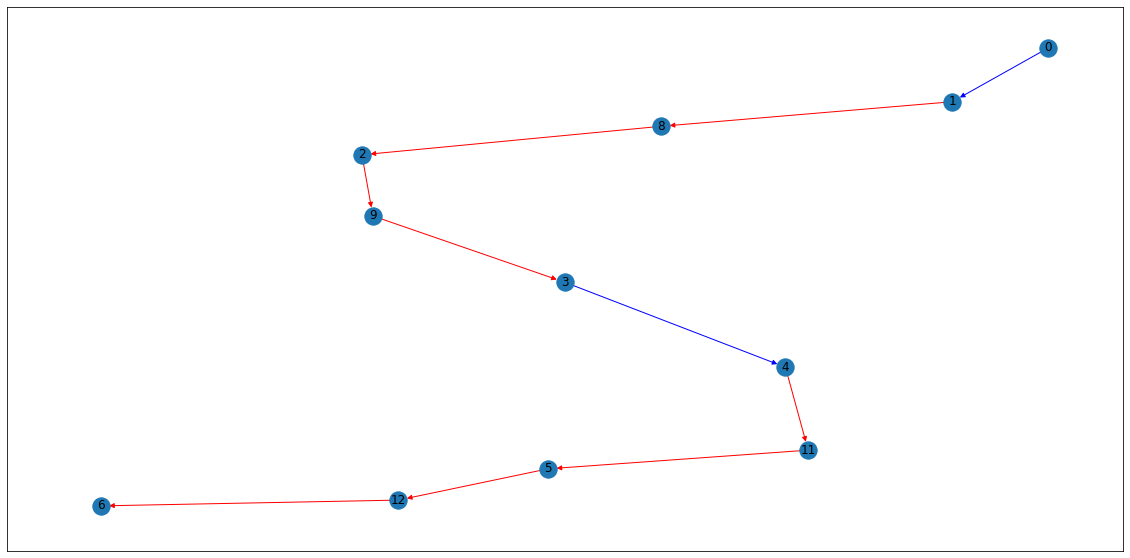

In [4]:
# Display

# get the variables
xs = m.vars

# for x in xs:
#    if x.x > 0:
#        print(f"{x.name} id:{x.idx} = {x.x}")

# display solution
import math

import networkx
import matplotlib
import matplotlib.pyplot as plt

if status == OptimizationStatus.Optimal or status == OptimizationStatus.Feasible:
    plt.figure(figsize=(20,10))
    
    edges = [x.edge for x in g.vars if not math.isclose(x.x, 0, abs_tol=0.001)]
    g = networkx.DiGraph()
    g.add_edges_from(edges)
    pos = networkx.spring_layout(g)
    networkx.draw_networkx_nodes(g, pos, nodelist=g.nodes)
    labels = {i: i for i in g.nodes}
    networkx.draw_networkx_labels(g, pos, labels=labels)


    one_edges = [e for e in g.edges if e[0] < len(w) and e[1] < len(w)]
    networkx.draw_networkx_edges(g, pos, edgelist=one_edges, edge_color='b')
    
    zero_edges = [e for e in g.edges if e not in one_edges]
    networkx.draw_networkx_edges(g, pos, edgelist=zero_edges, edge_color='r')
    
    plt.show()
